# Hand Gestures Classification using One-Shot Learning with Siamese Networks

This notebook creates and trains a Siamese network to classify hand gestures into 15 classes. I have used the convolutional base from the VGG16 network (pre-trained on the ImageNet dataset), built a Siamese network on top of it, and trained it on an American Sign Language (ASL) dataset. This model achieved 89.87% accuracy when tested on a 15-classes hand gestures dataset, created by myself.

Let us start by importing the required modules.

In [1]:
import numpy as np
import pandas as pd
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import os, shutil
import random
from itertools import permutations
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import keras.backend.tensorflow_backend as tfback
import tensorflow as tf

def _get_available_gpus():
    """
    Get a list of available GPU devices (formatted as strings).

    Returns: a list of available GPU devices.
    """
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

I now unzip the American Sign Language dataset, from a `.zip` file downloaded and saved on my Google Drive.

In [ ]:
from google.colab import drive
drive.mount('gdrive')

In [ ]:
!unzip 'gdrive/My Drive/asl_hand_gestures.zip' -d '.'

The following code organizes the images (original images, not the grayscale or resized or rotated images, which are also included in this dataset directory) into the respective classes. We have 24 classes, each representing a letter of the English alphabet ('J' and 'Z' are left out as they are represented by dynamic gestures), and each class has 40 images, 5 by each of 8 people.

In [5]:
import os
import shutil

base_dir = 'Dataset ASL Hand Gestures/original_frames'

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

classes = []

pics_list = [pic for pic in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, pic))]

for pic in pics_list:
    if pic[0] not in classes:
        os.mkdir(os.path.join(train_dir, pic[0]))
        classes.append(pic[0])

for pic in pics_list:
    img_src = os.path.join(base_dir, pic)
    img_dst = os.path.join(train_dir, f'{pic[0]}/{pic}')
    shutil.move(img_src, img_dst)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for gesture in os.listdir(train_dir):
    gesture_dir = os.path.join(test_dir, gesture)
    os.mkdir(gesture_dir)
    L1 = os.listdir(os.path.join(train_dir, gesture))
    L2 = np.random.choice(40, 10, replace=False)
    for i in L2:
        img_src = os.path.join(os.path.join(train_dir, gesture), L1[i])
        img_dst = os.path.join(gesture_dir, L1[i])
        shutil.move(img_src, img_dst)

In [6]:
base_dir = 'Dataset ASL Hand Gestures/original_frames'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

The following function loads images and corresponding labels into NumPy arrays.

In [7]:
def load_imgs(path):
    """
    Loads images and labels into NumPy arrays, and returns the arrays.

    Parameters:
    path - Path to the directory containing images (organized into subdirectories for each gesture).
    """

    X = []
    y = []

    imgs_per_class = min([len(os.listdir(os.path.join(path, gesture))) for gesture in os.listdir(path)])

    for gesture in os.listdir(path):
        gesture_images = []
        for i, filename in enumerate(os.listdir(os.path.join(path, gesture))):
            if i == imgs_per_class:
                break
            image_path = os.path.join(os.path.join(path, gesture), filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(96, 96))
            image = image/255.
            gesture_images.append(image)
            y.append(gesture)
        try:
            X.append(np.stack(gesture_images))
        except ValueError as e:
            print(e)

    y = np.vstack(y)
    X = np.stack(X)
    return X, y

data, y = load_imgs(train_dir)

In [8]:
data.shape

(24, 30, 96, 96, 3)

The following function generates (anchor, positive, negative) triplets to train the model.

In [9]:
def create_triplets(X, A_P, A_N, val_size):
    """
    Returns a NumPy array containing triplets of the form (Anchor, Positive, Negative).

    Parameters:
    X - NumPy array of images.
    A_P - Number of positive pairs of images to be used.
    A_N - Number of negative images to be used per positive pair.
    val_size - Fraction of triplets to be used for validation.
    """
    train_triplets = []
    val_triplets = []

    for gesture in range(X.shape[0]):
        ppairs = random.sample(list(permutations(range(X.shape[1]), 2)), k=A_P)
        
        L = []
        for i in range(0, X.shape[0]*X.shape[1]):
            if i not in range(gesture*X.shape[1], (gesture+1)*X.shape[1]):
                L.append(i)
        
        abs_index = np.random.choice(L, size=(A_N,), replace=False)
        n_classes = np.array([[i//X.shape[1], i%X.shape[1]] for i in abs_index])
        p_len = len(ppairs)

        for pair in ppairs[int(val_size*p_len):]:
            anchor = X[gesture, pair[0]]
            positive = X[gesture, pair[1]]
            for n in range(A_N):
                negative = X[n_classes[n][0], n_classes[n][1]]
                train_triplets.append([anchor, positive, negative])
        
        for pair in ppairs[:int(val_size*p_len)]:
            anchor = X[gesture, pair[0]]
            positive = X[gesture, pair[1]]
            for n in range(A_N):
                negative = X[n_classes[n][0], n_classes[n][1]]
                val_triplets.append([anchor, positive, negative])

    train_triplets = np.array(train_triplets)
    val_triplets = np.array(val_triplets)

    return train_triplets, val_triplets

In [10]:
X_train, X_val = create_triplets(data, 24, 24, 0.2)
X_train.shape, X_val.shape

((11520, 3, 96, 96, 3), (2304, 3, 96, 96, 3))

Let us check out a triplet, just to ensure everything is alright here.

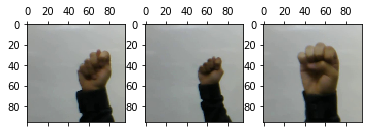

In [12]:
inx = 4242
img = X_train[inx].copy()
triplet = [img[0], img[1], img[2]]

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(triplet[0])
ax2.matshow(triplet[1])
ax3.matshow(triplet[2])
plt.show()

The following function builds and returns the base CNN model, built on top of the pretrained VGG16 convolutional base.

In [13]:
from keras.applications import VGG16

def base_CNN(input_shape):
    """
    Returns the base CNN that converts images to encodings.

    Parameters:
    input_shape - Input shape for the CNN.
    """
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    conv_base.trainable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64))

    return model

The following function returns the value of triplet loss for a given set of triplets.

In [14]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Returns the value of triplet loss

    Parameters:
    y_true - True labels, required when defining a loss function in Keras, but unused in this function.
    y_pred - Python list containing three parts:
                anchor - encodings for the anchor images
                positive - encodings for the positive images
                negative - encodings for the negative images
    alpha - A hyperparameter, higher values of which try to make the model give more distant encodings for different gesture classes.
    """
    
    total_length = y_pred.shape.as_list()[-1]
    
    anchor = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

    pos_dist = K.sum(K.square(anchor-positive), axis=1)
    neg_dist = K.sum(K.square(anchor-negative), axis=1)

    loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
 
    return loss

In [15]:
input_shape = (96, 96, 3)

We now build up the model, sharing the CNN along with its weights for all three input images in the triplet, and we output an array obtained by concatenating all three encodings. The model is compiled, and a checkpoint callback is initialized to save the model between epochs.

In [35]:
shared_cnn = base_CNN(input_shape)

anchor_input = Input(input_shape, name='anchor_input')
positive_input = Input(input_shape, name='positive_input')
negative_input = Input(input_shape, name='negative_input')

encoded_anchor = shared_cnn(anchor_input)
encoded_positive = shared_cnn(positive_input)
encoded_negative = shared_cnn(negative_input)

checkpoint = ModelCheckpoint('final_weights.h5', verbose=1, save_best_only=True)

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)

optimizer = Adam(lr=5e-4)
model.compile(loss=triplet_loss, optimizer=optimizer)

In [36]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64)           15312896    anchor_input[0][0]               
                                                                 positive_input[0][0]       

We now set up training and validation anchors, positives, and negatives, and then we train the model!

In [37]:
np.random.shuffle(X_train)
np.random.shuffle(X_val)

Anchor = X_train[:,0]
Positive = X_train[:,1]
Negative = X_train[:,2]
Anchor_val = X_val[:,0]
Positive_val = X_val[:,1]
Negative_val = X_val[:,2]

print(Anchor.shape)
Y_dummy = np.empty((Anchor.shape[0], 300))
Y_dummy2 = np.empty((Anchor_val.shape[0], 1))

(11520, 96, 96, 3)


In [38]:
model.fit([Anchor,Positive,Negative],
          y=Y_dummy,
          validation_data=([Anchor_val,Positive_val,Negative_val], Y_dummy2),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint])

Train on 11520 samples, validate on 2304 samples
Epoch 1/5
11520/11520 [==============================] - 23s 2ms/step - loss: 0.0304 - val_loss: 0.0222

Epoch 00001: val_loss improved from inf to 0.02221, saving model to final_weights.h5
Epoch 2/5
11520/11520 [==============================] - 23s 2ms/step - loss: 0.0032 - val_loss: 0.0182

Epoch 00002: val_loss improved from 0.02221 to 0.01820, saving model to final_weights.h5
Epoch 3/5
11520/11520 [==============================] - 23s 2ms/step - loss: 0.0037 - val_loss: 0.0200

Epoch 00003: val_loss did not improve from 0.01820
Epoch 4/5
11520/11520 [==============================] - 23s 2ms/step - loss: 0.0029 - val_loss: 0.0155

Epoch 00004: val_loss improved from 0.01820 to 0.01549, saving model to final_weights.h5
Epoch 5/5
11520/11520 [==============================] - 23s 2ms/step - loss: 0.0041 - val_loss: 0.0840

Epoch 00005: val_loss did not improve from 0.01549


We now set all layers as trainable, for fine-tuning, compile the model again, and train again.

In [39]:
model.load_weights('final_weights.h5')

for L in shared_cnn.layers:
    L.trainable = True
model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)

optimizer = Adam(lr=1e-4)
model.compile(loss=triplet_loss, optimizer=optimizer)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64)           15312896    anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [40]:
checkpoint2 = ModelCheckpoint('final_finetuned_weights.h5', verbose=1, save_best_only=True)
model.fit([Anchor,Positive,Negative],
          y=Y_dummy,
          validation_data=([Anchor_val, Positive_val, Negative_val], Y_dummy2),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint2])

Train on 11520 samples, validate on 2304 samples
Epoch 1/5
11520/11520 [==============================] - 53s 5ms/step - loss: 0.0225 - val_loss: 0.0383

Epoch 00001: val_loss improved from inf to 0.03834, saving model to final_finetuned_weights.h5
Epoch 2/5
11520/11520 [==============================] - 52s 5ms/step - loss: 0.0059 - val_loss: 0.0028

Epoch 00002: val_loss improved from 0.03834 to 0.00281, saving model to final_finetuned_weights.h5
Epoch 3/5
11520/11520 [==============================] - 52s 5ms/step - loss: 0.0046 - val_loss: 0.0120

Epoch 00003: val_loss did not improve from 0.00281
Epoch 4/5
11520/11520 [==============================] - 52s 5ms/step - loss: 0.0045 - val_loss: 0.0050

Epoch 00004: val_loss did not improve from 0.00281
Epoch 5/5
11520/11520 [==============================] - 52s 5ms/step - loss: 0.0038 - val_loss: 0.0118

Epoch 00005: val_loss did not improve from 0.00281


In [41]:
final_model = Model(inputs=anchor_input, outputs=encoded_anchor)

final_model.load_weights('final_finetuned_weights.h5')

We now have our final model, trained and ready to test!

The following three functions are required to test the model.

In [33]:
def img_to_encoding(image_path, model):
    """
    Returns encoding for a given image.

    Parameters:
    image_path - Path to the image to be encoded.
    model - The model used for classification.
    """
    img1 = cv2.imread(image_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (96,96))
    img = img1/255.
    encoding = model.predict_on_batch(np.array([img]))
    return encoding

In [24]:
def finder(image_path, database, model):
    """
    Returns the gesture class closest to the given image (and the corresponding distance), using L2 norm of difference between encodings to measure distance.
    
    Parameters:
    image_path - Path to the image to be classified.
    database - A dictionary containing the encodings of sample images from all gesture classes.
    model - The model used for classification.
    """
    encoding = img_to_encoding(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():
        dist = np.linalg.norm(db_enc - encoding)
        if dist < min_dist:
            min_dist = dist
            identity = name

    return min_dist, identity

In [25]:
def test_accuracy(path, database, model):
    """
    Returns the accuracy, correct classifications, and total images classified while testing a trained model on a dataset.

    Parameters:
    path - Path to the directory containing the test dataset.
    database - A dictionary containing the encodings of sample images from all gesture classes.
    model - The model used for classification.
    """
    correct = 0
    total = 0
    for gesture in os.listdir(path):
        subpath = os.path.join(path, gesture)
        for image in os.listdir(subpath):
            total += 1
            image_path = os.path.join(subpath, image)
            dist, identity = finder(image_path, database, model)
            if(identity == gesture):
                correct += 1

    return (correct/total)*100, correct, total

I now unzip my own hand gestures dataset, which has 15 classes, each with 25 images.

In [ ]:
!unzip 'gdrive/My Drive/gestures_dataset_2.zip' -d '.'

In [27]:
os.mkdir('refined_data')

The following code organizes the data.

In [30]:
for i in range(1,16):
    os.mkdir(f'refined_data/{i-1}')
    for j, img in enumerate(os.listdir(f'gestures_dataset_2/{i}/')):
        img = cv2.imread(os.path.join(f'gestures_dataset_2/{i}/', img))
        img = cv2.flip(img, 1)
        cv2.imwrite(f'refined_data/{i-1}/{j}.jpg', img)

Let us visualize an image from this dataset.

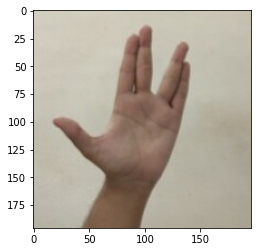

In [31]:
img = cv2.imread('refined_data/8/20.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

The following code tests the model on this hand gestures dataset.

In [42]:
database = {}

for gesture in os.listdir('refined_data'):
    image1 = os.listdir(os.path.join('refined_data', gesture))[3]
    path = os.path.join('refined_data', gesture, image1)
    database[gesture] = img_to_encoding(path, final_model)

print(test_accuracy('refined_data', database, final_model))

(89.86666666666666, 337, 375)


Well, with a good accuracy, we can now save the model! The architecture is stored in a `.json` file, and the weights in a `.h5` file.

In [43]:
final_model.save_weights('gdrive/My Drive/final_gestures_weights.h5')

model_json = final_model.to_json()
json_file = open('gdrive/My Drive/final_gestures_model.json', 'w')
json_file.write(model_json)
json_file.close()